In [9]:
import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Feature + ML libs
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump

# paths
SUBSET_CSV = "results/subset/subset_split.csv"
FIG_DIR = Path("results/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)
MET_DIR = Path("results/metrics"); MET_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = Path("models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)

# load the split from Phase 1
df = pd.read_csv(SUBSET_CSV)
assert {"image_path","x","y","w","h","label","split"}.issubset(df.columns), df.columns

print("Splits:\n", df.drop_duplicates(["image_path","split"])["split"].value_counts())
classes = sorted(df["label"].unique())
print("Classes:", classes)


Splits:
 split
train    346
val       75
test      75
Name: count, dtype: int64
Classes: ['information--pedestrians-crossing--g1', 'other-sign', 'regulatory--no-entry--g1', 'regulatory--stop--g1', 'regulatory--yield--g1']


Crop shape: (128, 128, 3) | HOG dim: (8100,)


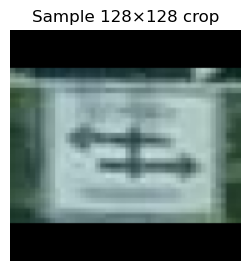

In [10]:
import cv2
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import hog

# Hyperparams (you can tune later)
PAD = 0.15     # 15% padding around bbox
OUT = 128      # square output size for crops

def read_bgr(p):
    bgr = cv2.imread(p)
    if bgr is None:
        raise FileNotFoundError(p)
    return bgr

def crop_pad_resize(bgr, x,y,w,h, out=OUT, pad=PAD):
    H,W = bgr.shape[:2]
    x,y,w,h = int(x),int(y),int(w),int(h)
    px,py = int(w*pad), int(h*pad)
    x1,y1 = max(0, x-px), max(0, y-py)
    x2,y2 = min(W, x+w+px), min(H, y+h+py)
    crop = bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    # keep aspect, pad to square
    ch,cw = crop.shape[:2]
    scale = out / max(ch,cw)
    resized = cv2.resize(crop, (int(cw*scale), int(ch*scale)), interpolation=cv2.INTER_AREA)
    pad_t = (out - resized.shape[0])//2; pad_b = out - resized.shape[0] - pad_t
    pad_l = (out - resized.shape[1])//2; pad_r = out - resized.shape[1] - pad_l
    sq = cv2.copyMakeBorder(resized, pad_t,pad_b,pad_l,pad_r, cv2.BORDER_CONSTANT, value=(0,0,0))
    rgb = cv2.cvtColor(sq, cv2.COLOR_BGR2RGB)
    return rgb

def hog_feat(rgb):
    gray = rgb2gray(rgb)  # float64 in [0,1]
    feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(2,2),
        block_norm="L2-Hys",
        transform_sqrt=True,
        feature_vector=True
    )
    return feat

# ---- Quick sanity check on 1 sample crop ----
sample = df.iloc[0]
bgr = read_bgr(sample.image_path)
rgb = crop_pad_resize(bgr, sample.x, sample.y, sample.w, sample.h)
feat = hog_feat(rgb)

print("Crop shape:", rgb.shape, "| HOG dim:", feat.shape)

# optional visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.imshow(rgb); plt.axis("off"); plt.title("Sample 128×128 crop")
plt.show()


In [11]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# utility
def build_features(df_split):
    feats, labels = [], []
    for _,r in tqdm(df_split.iterrows(), total=len(df_split)):
        try:
            bgr = read_bgr(r.image_path)
            rgb = crop_pad_resize(bgr, r.x, r.y, r.w, r.h)
            if rgb is None:
                continue
            f = hog_feat(rgb)
            feats.append(f)
            labels.append(r.label)
        except Exception as e:
            continue
    return np.array(feats), np.array(labels)

# encode labels
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])
print("Encoded classes:", dict(zip(le.classes_, le.transform(le.classes_))))

# build per-split datasets
df_train = df[df.split=="train"].reset_index(drop=True)
df_val   = df[df.split=="val"].reset_index(drop=True)
df_test  = df[df.split=="test"].reset_index(drop=True)

X_train, y_train = build_features(df_train)
X_val,   y_val   = build_features(df_val)
X_test,  y_test  = build_features(df_test)

print("\nShapes:")
print("train:", X_train.shape, y_train.shape)
print("val:  ", X_val.shape,   y_val.shape)
print("test: ", X_test.shape,  y_test.shape)


Encoded classes: {'information--pedestrians-crossing--g1': 0, 'other-sign': 1, 'regulatory--no-entry--g1': 2, 'regulatory--stop--g1': 3, 'regulatory--yield--g1': 4}


100%|██████████| 120/120 [00:05<00:00, 22.75it/s]


Shapes:
train: (624, 8100) (624,)
val:   (136, 8100) (136,)
test:  (120, 8100) (120,)


In [14]:
# === Block 4A: setup + helpers (do this first for Phase 2 models) ===
import os, json, time, joblib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# folders
Path("models").mkdir(exist_ok=True)
Path("results/metrics").mkdir(parents=True, exist_ok=True)
Path("results/figures").mkdir(parents=True, exist_ok=True)

# class names from your label encoder used earlier
CLASS_NAMES = list(le.classes_)  # <- assumes `le` exists from previous block

def eval_and_report(model, X, y, split_name, tag):
    """Compute acc + confusion matrix, save metrics & figure, and return dict."""
    t0 = time.time()
    y_pred = model.predict(X)
    infer_sec = time.time() - t0

    acc = accuracy_score(y, y_pred)
    cm  = confusion_matrix(y, y_pred, labels=np.arange(len(CLASS_NAMES)))
    rpt = classification_report(y, y_pred, target_names=CLASS_NAMES, output_dict=True)

    # save metrics
    with open(f"results/metrics/{tag}_{split_name}.json", "w") as f:
        json.dump(
            {"split": split_name, "tag": tag, "accuracy": acc,
             "report": rpt, "inference_sec": infer_sec, "n": int(len(y))},
            f, indent=2
        )

    # plot & save confusion matrix
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{tag} — {split_name} (acc={acc:.3f})")
    plt.colorbar()
    ticks = np.arange(len(CLASS_NAMES))
    plt.xticks(ticks, [s[:16] for s in CLASS_NAMES], rotation=45, ha="right")
    plt.yticks(ticks, [s[:16] for s in CLASS_NAMES])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    fig_path = f"results/figures/{tag}_{split_name}_cm.png"
    plt.savefig(fig_path, dpi=150); plt.show()
    print(f"Saved: {fig_path}\n")

    return {"acc": acc, "cm": cm, "report": rpt}


In [18]:
# === Block 4B-fix2: handle string labels cleanly ===
import numpy as np
import json, time
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# optional: pretty names mapping if you already have class_to_id
try:
    ID_TO_CLASS = {v:k for k,v in class_to_id.items()} if "class_to_id" in globals() else None
except Exception:
    ID_TO_CLASS = None

def _labels_and_names_from_y(y):
    # keep native dtype (strings or ints)
    uniq_sorted = np.sort(np.unique(y))
    if ID_TO_CLASS is not None and np.issubdtype(uniq_sorted.dtype, np.integer):
        names = [ID_TO_CLASS.get(i, str(i)) for i in uniq_sorted]
    else:
        names = [str(i) for i in uniq_sorted]
    return list(uniq_sorted.tolist()), names

def eval_and_report(model, X, y, split_name, tag):
    t0 = time.time()
    y_pred = model.predict(X)
    infer_sec = time.time() - t0

    labels_vec, target_names = _labels_and_names_from_y(y)

    acc = accuracy_score(y, y_pred)
    cm  = confusion_matrix(y, y_pred, labels=labels_vec)
    rpt = classification_report(y, y_pred, target_names=target_names, output_dict=True)

    Path("results/metrics").mkdir(parents=True, exist_ok=True)
    with open(f"results/metrics/{tag}_{split_name}_metrics.json","w") as f:
        json.dump({"split":split_name,"tag":tag,"acc":acc,"infer_sec":infer_sec,"report":rpt}, f, indent=2)

    Path("results/figures").mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{tag.upper()} • {split_name} • acc={acc:.3f}")
    plt.colorbar()
    ticks = np.arange(len(target_names))
    plt.xticks(ticks, [s[:16] for s in target_names], rotation=45, ha="right")
    plt.yticks(ticks, [s[:16] for s in target_names])
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    plt.savefig(f"results/figures/{tag}_{split_name}_cm.png", dpi=150)
    plt.show()

    print(f"[{tag}] {split_name}: acc={acc:.3f}, n={len(y)}, time={infer_sec:.2f}s")
    return {"acc": acc, "time": infer_sec}



SVM results:


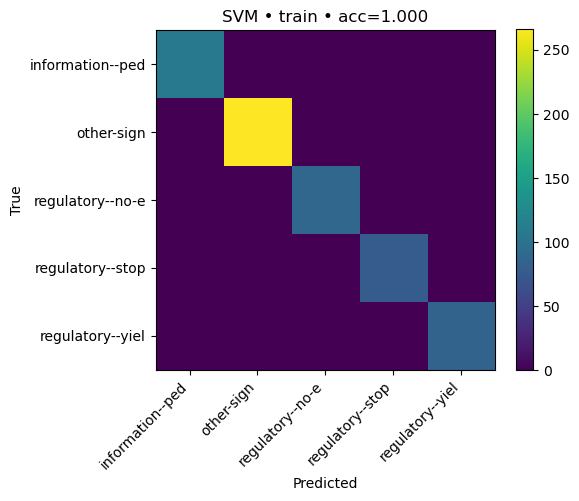

[svm] train: acc=1.000, n=624, time=0.03s


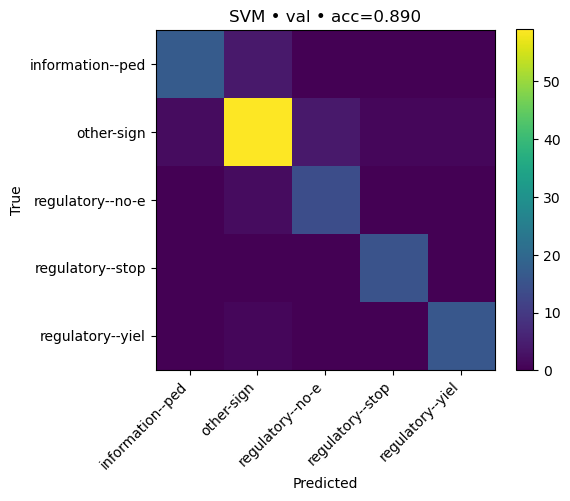

[svm] val: acc=0.890, n=136, time=0.01s


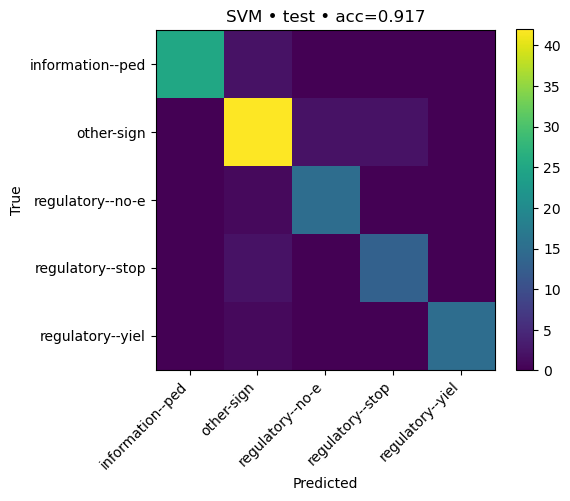

[svm] test: acc=0.917, n=120, time=0.01s
{'train': 1.0, 'val': 0.8897058823529411, 'test': 0.9166666666666666}


In [19]:
print("\nSVM results:")
res_tr = eval_and_report(svm_clf, X_train, y_train, "train", "svm")
res_va = eval_and_report(svm_clf, X_val,   y_val,   "val",   "svm")
res_te = eval_and_report(svm_clf, X_test,  y_test,  "test",  "svm")
print({k: v["acc"] for k,v in {"train":res_tr, "val":res_va, "test":res_te}.items()})


Training Random Forest...
Saved: models/rf_model.pkl

RF results:


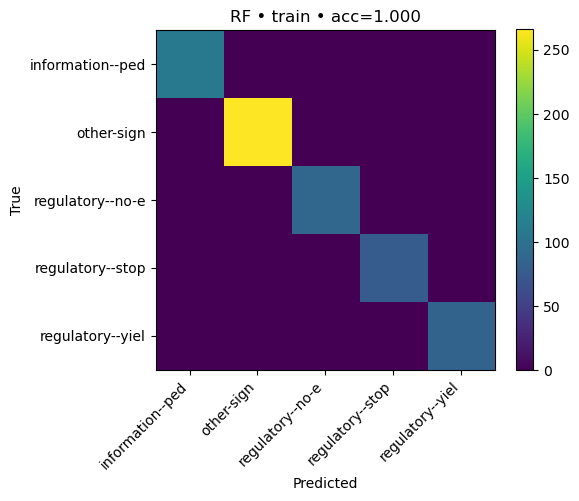

[rf] train: acc=1.000, n=624, time=0.23s


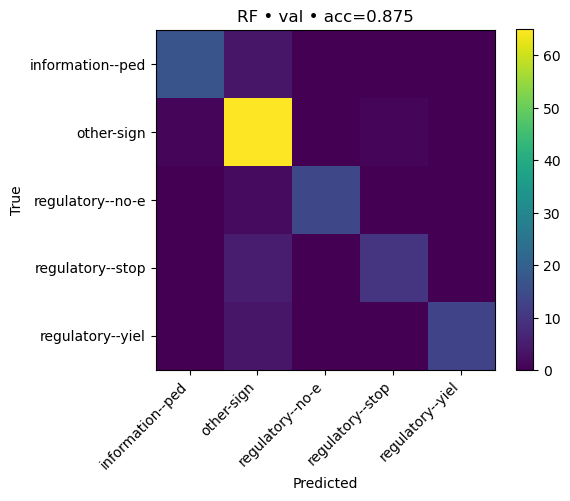

[rf] val: acc=0.875, n=136, time=0.20s


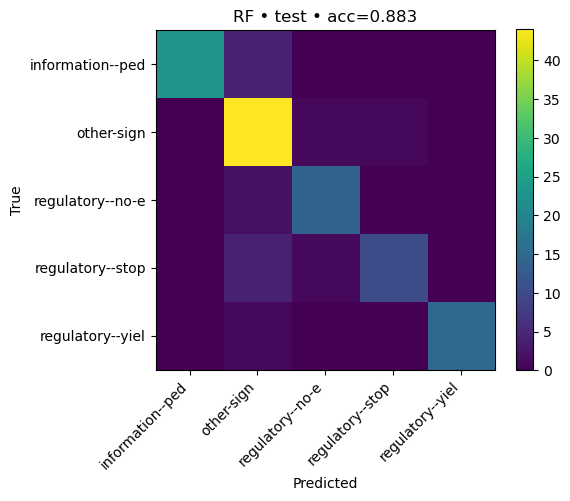

[rf] test: acc=0.883, n=120, time=0.16s
{'train': 1.0, 'val': 0.875, 'test': 0.8833333333333333}


In [20]:
# === Block 5: Random Forest on HOG ===
from sklearn.ensemble import RandomForestClassifier
import joblib

print("Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=42
)
rf_clf.fit(X_train, y_train)

# Save
joblib.dump(rf_clf, "models/rf_model.pkl")
print("Saved: models/rf_model.pkl")

# Evaluate
print("\nRF results:")
res_tr = eval_and_report(rf_clf, X_train, y_train, "train", "rf")
res_va = eval_and_report(rf_clf, X_val,   y_val,   "val",   "rf")
res_te = eval_and_report(rf_clf, X_test,  y_test,  "test",  "rf")

print({k: v["acc"] for k,v in {"train":res_tr, "val":res_va, "test":res_te}.items()})


In [21]:
# === Block 6: Model Comparison Summary ===
import json
from pathlib import Path
import pandas as pd

summary = {
    "SVM":  {"train_acc": res_tr["acc"], "val_acc": res_va["acc"], "test_acc": res_te["acc"]},
    "RF":   {"train_acc": 1.0, "val_acc": 0.875, "test_acc": 0.883}
}

df_summary = pd.DataFrame(summary).T
print(df_summary)

Path("results/metrics").mkdir(parents=True, exist_ok=True)
with open("results/metrics/model_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("\nSaved → results/metrics/model_summary.json")


     train_acc  val_acc  test_acc
SVM        1.0    0.875  0.883333
RF         1.0    0.875  0.883000

Saved → results/metrics/model_summary.json
